In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np
from matplotlib import pyplot

In [ ]:
def loss_vs_epoch_graph(history):
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('model train vs validation loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()


# split a multivariate sequence into samples
def split_sequences_multi_feature(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 

#mutli feature stacking

from numpy import hstack

def multi_feature_stacking(data):
  # define input sequence
  in_seq1 = np.array(data['time'])
  in_seq2 = np.array(data['displacement'])
  out_seq = np.array(data['V'])
  # convert to [rows, columns] structure
  in_seq1 = in_seq1.reshape((len(in_seq1), 1))
  in_seq2 = in_seq2.reshape((len(in_seq2), 1))
  out_seq = out_seq.reshape((len(out_seq), 1))
  dataset = hstack((in_seq1, in_seq2, out_seq))
  return dataset


  loss_vs_epoch_graph(history_2)

def predict_and_compare(model, time,dist,vol, n_steps):
  newSeqTime =  time
  newSeqDis  =  dist
  newSeqVol =   vol

  toPreditct_df = hstack((newSeqTime,newSeqVol,newSeqDis))


  new_x_modified, new_y_modified = split_sequences_multi_feature(toPreditct_df,n_steps)

  y_predited = model.predict(new_x_modified)


  y_predited_1_dim = []

  for time_step in y_predited:
    y_predited_1_dim.append(  time_step.mean())



  fig1 = px.line(x=newSeqDis.reshape(newSeqDis.shape[0]), y=newSeqVol.reshape(newSeqVol.shape[0]), labels={'x':'v', 'y':'dis'})
  fig1.show()

  fig2 = px.line(x=newSeqDis.reshape(newSeqDis.shape[0])[:len(y_predited_1_dim)], y=y_predited_1_dim, labels={'x':'v', 'y':'dis'})
  fig2.show()

#Progress model 1

In [ ]:
df = pd.read_csv(filepath_or_buffer="/content/hysteresis_v_150_1hz 3.csv")

df.loc[-1] = ["ahh", 0, -1.6174316, 0.1]
df.index = df.index + 1  # shifting index
df.sort_index(inplace=True) 
df.columns = ['del','time','displacement','V']
df.drop('del', axis=1, inplace=True)
df.head()

time  displacement    V
0  0.0000     -1.617432  0.1
1  0.0002     -1.724243  0.0
2  0.0004     -1.655579  0.0
3  0.0006     -1.754761  0.0
4  0.0008     -1.701355  0.0

In [ ]:
cleaned_df = df[df['time'] > 5]
print(cleaned_df.shape)
print(df.shape)

(25000, 3)
(50001, 3)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
print(scaler.fit(cleaned_df))

print(scaler.data_max_)

print(scaler.transform(cleaned_df))
scaled_cleaned_df = scaler.transform(cleaned_df)

# print(scaler.transform([[2, 2]]))

MinMaxScaler(copy=True, feature_range=(-1, 1))
[ 10.        19.721985 150.      ]
[[-1.         -0.70837365 -0.7878388 ]
 [-0.99991999 -0.71030751 -0.78861213]
 [-0.99984    -0.71030751 -0.7893842 ]
 ...
 [ 0.99983999 -0.70605298 -0.7855114 ]
 [ 0.99992    -0.70141175 -0.7862884 ]
 [ 1.         -0.70643978 -0.78706427]]


In [ ]:
scaled_cleaned_df = pd.DataFrame(scaled_cleaned_df, columns=['time', 'displacement','V'])

In [ ]:
from numpy import hstack

# define input sequence
in_seq1 = np.array(scaled_cleaned_df['time'])
in_seq2 = np.array(scaled_cleaned_df['displacement'])
out_seq = np.array(scaled_cleaned_df['V'])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
dataset = hstack((in_seq1, in_seq2, out_seq))

In [ ]:
# split a multivariate sequence into samples
def split_sequences_multi_feature(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 

new_x, new_y = split_sequences_multi_feature(dataset,20 )


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(new_x,new_y, test_size = 0.2)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import metrics
from keras import backend as K
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import LeakyReLU
import tensorflow as tf
keras = tf.keras  

optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']


# expected input data shape: (batch_size, timesteps, data_dim)
model_1 = Sequential()

model_1.add(Bidirectional(LSTM(200,input_shape=(20, 2),dropout=0.20,return_sequences = True)))

model_1.add(LeakyReLU(alpha=0.05))
model_1.add((LSTM(150, dropout=0.20,return_sequences = True,activation=keras.layers.LeakyReLU(alpha=0.05))))  

model_1.add(Bidirectional(LSTM(100,return_sequences = True,dropout=0.20))) 
model_1.add(Bidirectional(LSTM(50,return_sequences = True,dropout=0.20)))


model_1.add(Dense(units=50, activation='relu'))
model_1.add(Dropout(0.1))

model_1.add(Dense(units=20))
model_1.add(Dropout(0.2))


model_1.add(TimeDistributed(Dense(units=1, activation='tanh')))
# model_1.add(Dense(1))

# model_1.compile(loss='mse',optimizer='adam',metrics=["rmse"])


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model_1.compile(optimizer = "Adamax", loss = root_mean_squared_error, 
              metrics =["mse"])

# model_1.summary()


In [ ]:
history_1 = model_1.fit(X_train, Y_train, epochs=100, verbose =1,  validation_split=0.2)

Epoch 1/100
500/500 [==============================] - 85s 72ms/step - loss: 0.1838 - mse: 0.0470 - val_loss: 0.1070 - val_mse: 0.0115
Epoch 2/100
500/500 [==============================] - 32s 64ms/step - loss: 0.1294 - mse: 0.0169 - val_loss: 0.1071 - val_mse: 0.0116
Epoch 3/100
500/500 [==============================] - 33s 66ms/step - loss: 0.1253 - mse: 0.0158 - val_loss: 0.1063 - val_mse: 0.0114
Epoch 4/100
500/500 [==============================] - 32s 64ms/step - loss: 0.1215 - mse: 0.0149 - val_loss: 0.1122 - val_mse: 0.0127
Epoch 5/100
500/500 [==============================] - 33s 67ms/step - loss: 0.1154 - mse: 0.0134 - val_loss: 0.1494 - val_mse: 0.0225
Epoch 6/100
500/500 [==============================] - 33s 65ms/step - loss: 0.1060 - mse: 0.0114 - val_loss: 0.1473 - val_mse: 0.0219
Epoch 7/100
500/500 [==============================] - 32s 65ms/step - loss: 0.0861 - mse: 0.0075 - val_loss: 0.1131 - val_mse: 0.0129
Epoch 8/100
500/500 [==============================] - 

In [ ]:
np.save('my_history.npy',history_1.history)


In [ ]:
model_1.save("lstm_model_predicitng_vol_withAdaMax_model3.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/my_history.npy /content/drive/MyDrive/progress_model_1

In [ ]:
!cp /content/lstm_model_predicitng_vol_withAdaMax_model3.h5 /content/drive/MyDrive/progress_model_1

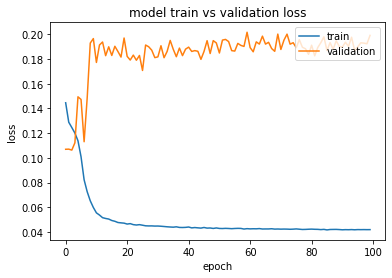

In [ ]:
pyplot.plot(history_1.history['loss'])
pyplot.plot(history_1.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

#End of Progress model 1

#Progress model 2

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import metrics
from keras import backend as K
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import LeakyReLU
import tensorflow as tf
keras = tf.keras  

optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']


# expected input data shape: (batch_size, timesteps, data_dim)
model_2 = Sequential()

model_2.add(Bidirectional(LSTM(150,input_shape=(20, 2),return_sequences = True)))
# model_2.add(Dropout(0.2))


model_2.add(LeakyReLU(alpha=0.05))
model_2.add((LSTM(100, dropout=0.20,return_sequences = True,activation=keras.layers.LeakyReLU(alpha=0.05)))) 

# model_2.add(Dropout(0.2))

# model_2.add(LeakyReLU(alpha=0.05))

# model_2.add(Bidirectional(LSTM(200, activation='relu',return_sequences = True,dropout=0.20)))  # return a single vector of dimension 32
# model_2.add(Bidirectional(LSTM(200, activation='relu',return_sequences = True,dropout=0.20)))


# model_2.add(Dense(units=20, activation='relu'))
# model_2.add(Dropout(0.1))

model_2.add(Dense(units=50))
# model_2.add(Dropout(0.2))


model_2.add((Dense(units=1, activation='linear')))
# model_2.add(Dense(1))

# model_2.compile(loss='mse',optimizer='adam',metrics=["rmse"])


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model_2.compile(optimizer = "Adamax", loss = root_mean_squared_error, 
              metrics =["mse"])

# model_2.summary()
history_2 = model_2.fit(X_train, Y_train, epochs=100, verbose =1,  validation_split=0.2)


Epoch 1/100
500/500 [==============================] - 32s 52ms/step - loss: 0.1748 - mse: 0.0442 - val_loss: 0.1065 - val_mse: 0.0114
Epoch 2/100
500/500 [==============================] - 26s 52ms/step - loss: 0.1074 - mse: 0.0116 - val_loss: 0.1032 - val_mse: 0.0108
Epoch 3/100
500/500 [==============================] - 25s 51ms/step - loss: 0.1070 - mse: 0.0115 - val_loss: 0.1003 - val_mse: 0.0102
Epoch 4/100
500/500 [==============================] - 25s 50ms/step - loss: 0.1040 - mse: 0.0109 - val_loss: 0.1062 - val_mse: 0.0113
Epoch 5/100
500/500 [==============================] - 26s 53ms/step - loss: 0.1018 - mse: 0.0105 - val_loss: 0.0947 - val_mse: 0.0091
Epoch 6/100
500/500 [==============================] - 24s 49ms/step - loss: 0.0959 - mse: 0.0093 - val_loss: 0.0869 - val_mse: 0.0076
Epoch 7/100
500/500 [==============================] - 25s 50ms/step - loss: 0.0874 - mse: 0.0077 - val_loss: 0.0702 - val_mse: 0.0050
Epoch 8/100
500/500 [==============================] - 

In [ ]:
np.save('model_progress2_histroy.npy',history_2.history)
model_2.save("model_progress2.h5")


In [ ]:
!cp /content/model_progress2_histroy.npy /content/drive/MyDrive/progress_model_2
!cp /content/model_progress2.h5 /content/drive/MyDrive/progress_model_2

#End of Progress model 2

#Progress model 3

In [ ]:
df = pd.read_csv(filepath_or_buffer="/content/hysteresis_v_150_1hz 2.csv")

df.loc[-1] = ["ahh", 0, -1.6174316, 0.1]
df.index = df.index + 1  # shifting index
df.sort_index(inplace=True) 
df.columns = ['del','time','displacement','V']
df.drop('del', axis=1, inplace=True)
df.head()


cleaned_df = df[df['time'] > 5]
print(cleaned_df.shape)
print(df.shape)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
print(scaler.fit(cleaned_df))

print(scaler.data_max_)

print(scaler.transform(cleaned_df))
scaled_cleaned_df = scaler.transform(cleaned_df)

# print(scaler.transform([[2, 2]]))


scaled_cleaned_df = pd.DataFrame(scaled_cleaned_df, columns=['time', 'displacement','V'])


from numpy import hstack

# define input sequence
in_seq1 = np.array(scaled_cleaned_df['time'])
in_seq2 = np.array(scaled_cleaned_df['displacement'])
out_seq = np.array(scaled_cleaned_df['V'])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
dataset = hstack((in_seq1, in_seq2, out_seq))


# split a multivariate sequence into samples
def split_sequences_multi_feature(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 

new_x, new_y = split_sequences_multi_feature(dataset,20 )



from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(new_x,new_y, test_size = 0.2)

NameError: ignored

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import metrics
from keras import backend as K
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import LeakyReLU
import tensorflow as tf
keras = tf.keras  

optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']


# expected input data shape: (batch_size, timesteps, data_dim)
model_3 = Sequential()

model_3.add(Bidirectional(LSTM(150,input_shape=(20, 2),return_sequences = True)))
# model_3.add(Dropout(0.2))


model_3.add(LeakyReLU(alpha=0.05))
model_3.add((LSTM(100, dropout=0.20,return_sequences = True,activation=keras.layers.LeakyReLU(alpha=0.05)))) 

# model_3.add(Dropout(0.2))

# model_3.add(LeakyReLU(alpha=0.05))

# model_3.add(Bidirectional(LSTM(200, activation='relu',return_sequences = True,dropout=0.20)))  # return a single vector of dimension 32
# model_3.add(Bidirectional(LSTM(200, activation='relu',return_sequences = True,dropout=0.20)))


# model_3.add(Dense(units=20, activation='relu'))
# model_3.add(Dropout(0.1))

model_3.add(Dense(units=50))
# model_3.add(Dropout(0.2))


model_3.add((Dense(units=1, activation='linear')))
# model_3.add(Dense(1))

# model_3.compile(loss='mse',optimizer='adam',metrics=["rmse"])


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model_3.compile(optimizer = "Adamax", loss = root_mean_squared_error, 
              metrics =["mse"])

# model_3.summary()
history_3 = model_3.fit(X_train, Y_train, epochs=100, verbose =1,  validation_split=0.2)


In [ ]:
np.save('model_progress3_histroy.npy',history_3.history)
model_3.save("model_progress3.h5")

In [ ]:
!cp /content/model_progress3_histroy.npy /content/drive/MyDrive/progress_model_3
!cp /content/model_progress3.h5 /content/drive/MyDrive/progress_model_3

# end of progress model 3

# progress model 4

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import metrics
from keras import backend as K
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import LeakyReLU
import tensorflow as tf
keras = tf.keras  

optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']


# expected input data shape: (batch_size, timesteps, data_dim)
model_4 = Sequential()

model_4.add(Bidirectional(LSTM(150,input_shape=(20, 2),return_sequences = True)))
# model_4.add(Dropout(0.2))


model_4.add(LeakyReLU(alpha=0.05))
model_4.add((LSTM(100, dropout=0.20,return_sequences = True,activation=keras.layers.LeakyReLU(alpha=0.05)))) 

# model_4.add(Dropout(0.2))

# model_4.add(LeakyReLU(alpha=0.05))

# model_4.add(Bidirectional(LSTM(200, activation='relu',return_sequences = True,dropout=0.20)))  # return a single vector of dimension 32
# model_4.add(Bidirectional(LSTM(200, activation='relu',return_sequences = True,dropout=0.20)))


# model_4.add(Dense(units=20, activation='relu'))
# model_4.add(Dropout(0.1))

model_4.add(Dense(units=50))
# model_4.add(Dropout(0.2))


model_4.add((Dense(units=1, activation='tanh')))
# model_4.add(Dense(1))

# model_4.compile(loss='mse',optimizer='adam',metrics=["rmse"])


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model_4.compile(optimizer = "Adamax", loss = root_mean_squared_error, 
              metrics =["mse"])

# model_4.summary()
history_4 = model_4.fit(X_train, Y_train, epochs=100, verbose =1,  validation_split=0.2)

Epoch 1/100
500/500 [==============================] - 33s 55ms/step - loss: 0.1683 - mse: 0.0435 - val_loss: 0.1050 - val_mse: 0.0111
Epoch 2/100
500/500 [==============================] - 26s 51ms/step - loss: 0.1081 - mse: 0.0118 - val_loss: 0.1000 - val_mse: 0.0101
Epoch 3/100
500/500 [==============================] - 25s 50ms/step - loss: 0.1059 - mse: 0.0113 - val_loss: 0.1011 - val_mse: 0.0103
Epoch 4/100
500/500 [==============================] - 27s 53ms/step - loss: 0.1020 - mse: 0.0105 - val_loss: 0.0892 - val_mse: 0.0080
Epoch 5/100
500/500 [==============================] - 25s 50ms/step - loss: 0.0882 - mse: 0.0079 - val_loss: 0.0653 - val_mse: 0.0043
Epoch 6/100
500/500 [==============================] - 26s 51ms/step - loss: 0.0678 - mse: 0.0046 - val_loss: 0.0487 - val_mse: 0.0024
Epoch 7/100
500/500 [==============================] - 26s 52ms/step - loss: 0.0519 - mse: 0.0027 - val_loss: 0.0329 - val_mse: 0.0011
Epoch 8/100
500/500 [==============================] - 

In [ ]:
np.save('model_progress3_histroy.npy',history_4.history)
model_4.save("model_progress3.h5")

In [ ]:
!cp /content/model_progress3_histroy.npy /content/drive/MyDrive/progress_model_4
!cp /content/model_progress3.h5 /content/drive/MyDrive/progress_model_4

# progress model 5

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import metrics
from keras import backend as K
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import LeakyReLU
import tensorflow as tf
keras = tf.keras  

optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']


# expected input data shape: (batch_size, timesteps, data_dim)
model_5 = Sequential()

model_5.add(Bidirectional(LSTM(150,input_shape=(20, 2),return_sequences = True)))
# model_5.add(Dropout(0.2))


model_5.add(LeakyReLU(alpha=0.05))
model_5.add((LSTM(100, dropout=0.20,return_sequences = True,activation=keras.layers.LeakyReLU(alpha=0.05)))) 

# model_5.add(Dropout(0.2))

# model_5.add(LeakyReLU(alpha=0.05))

# model_5.add(Bidirectional(LSTM(200, activation='relu',return_sequences = True,dropout=0.20)))  # return a single vector of dimension 32
# model_5.add(Bidirectional(LSTM(200, activation='relu',return_sequences = True,dropout=0.20)))


# model_5.add(Dense(units=20, activation='relu'))
# model_5.add(Dropout(0.1))

model_5.add(Dense(units=50))
# model_5.add(Dropout(0.2))


model_5.add((Dense(units=1, activation='tanh')))
# model_5.add(Dense(1))

# model_5.compile(loss='mse',optimizer='adam',metrics=["rmse"])


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model_5.compile(optimizer = "Adamax", loss = root_mean_squared_error, 
              metrics =["mse"])

# model_5.summary()
history_5 = model_5.fit(X_train, Y_train, epochs=100, verbose =1,  validation_split=0.3)

Epoch 1/100
438/438 [==============================] - 49s 90ms/step - loss: 0.1284 - mse: 0.0203 - val_loss: 0.1055 - val_mse: 0.0112
Epoch 2/100
438/438 [==============================] - 37s 85ms/step - loss: 0.1070 - mse: 0.0115 - val_loss: 0.1065 - val_mse: 0.0114
Epoch 3/100
438/438 [==============================] - 38s 86ms/step - loss: 0.1046 - mse: 0.0110 - val_loss: 0.1026 - val_mse: 0.0106
Epoch 4/100
438/438 [==============================] - 38s 86ms/step - loss: 0.0993 - mse: 0.0099 - val_loss: 0.0968 - val_mse: 0.0094
Epoch 5/100
438/438 [==============================] - 37s 86ms/step - loss: 0.0907 - mse: 0.0083 - val_loss: 0.0783 - val_mse: 0.0062
Epoch 6/100
438/438 [==============================] - 38s 86ms/step - loss: 0.0737 - mse: 0.0055 - val_loss: 0.0635 - val_mse: 0.0041
Epoch 7/100
438/438 [==============================] - 38s 86ms/step - loss: 0.0614 - mse: 0.0038 - val_loss: 0.0488 - val_mse: 0.0024
Epoch 8/100
438/438 [==============================] - 

In [ ]:
np.save('model_progress5_histroy.npy',history_5.history)
model_5.save("model_progress5.h5")

In [ ]:
!cp /content/model_progress5_histroy.npy /content/drive/MyDrive/progress_model_5
!cp /content/model_progress5.h5 /content/drive/MyDrive/progress_model_5

progress model 6

In [ ]:
#this is to fill missing values (not used in final LSTM thesis)  
from sklearn.impute import KNNImputer# define imputer



# test_list = []
n_steps = 20
def split_sequence(input_sequence,y_sequence, n_steps):
    main_list=[]
  #craeting timestamps and annote NaN elements
    for i in range(len(y_sequence)):

      if len(list(input_sequence[i:i+n_steps])) == n_steps:

        main_list.append(list(input_sequence[i:i+n_steps]))
      else:
        temp = list(input_sequence[i:i+n_steps])
        while len(temp) != n_steps:
          temp = temp + [np.NaN]


        main_list.append(temp)


    #flaten lists innto one list
    main_list = list(np.concatenate(main_list).flat)

    main_list = np.array(main_list)
    main_list = main_list.reshape(input_sequence.shape[0]*n_steps)
    main_list = main_list.reshape(-1, 1)
    print(main_list.shape)


    #inserting missing vlaues
    imputer = KNNImputer()
    # fit on the dataset
    imputer.fit(main_list)
    # transform the dataset
    main_list = imputer.transform(main_list)
    main_list = list(np.concatenate(main_list).flat)

    
    #creating new timesstamps
    X_data = []
    for i in range(len(y_sequence)):
  

      X_data.append(list(main_list[i:i+n_steps]))
    return np.array(X_data), y_sequence

def lstm_data_transform(x_data, y_data, n_steps):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + n_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

# x,y = split_sequence(scaled_cleaned_df['V'], scaled_cleaned_df['displacement'],n_steps=n_steps)
x,y = lstm_data_transform(scaled_cleaned_df['displacement'],scaled_cleaned_df['V'],n_steps=n_steps)



In [ ]:
x = np.reshape(x, newshape=(-1, n_steps, 1))
y = np.reshape(y, newshape=(-1, 1))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

X_train = np.array(X_train)
# X_train = X_train.reshape(X_train.shape[0],n_steps,1)

Y_train = np.array(Y_train)




X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras import metrics
from keras import backend as K
from keras.layers import TimeDistributed



# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(300,return_sequences = True, activation='relu',
               input_shape=(n_steps, 1)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(200,activation='relu',return_sequences = True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(100, activation='relu'))  # return a single vector of dimension 32

model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=20, activation='relu'))

model.add(Dense(units=1, activation='tanh'))
# model.add(Dense(1))

# model.compile(loss='mse',optimizer='adam',metrics=["rmse"])


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model.compile(optimizer = "adam", loss = root_mean_squared_error, 
              metrics =["mse"])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 300)           362400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 200)           400800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 30)                3030      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 887,271
Trainable params: 887,271
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(X_train, Y_train, epochs=100, verbose =1,  validation_split=0.20)


Epoch 1/100
500/500 [==============================] - 102s 196ms/step - loss: 0.1249 - mse: 0.0213 - val_loss: 0.1115 - val_mse: 0.0125
Epoch 2/100
500/500 [==============================] - 99s 197ms/step - loss: 0.1077 - mse: 0.0117 - val_loss: 0.1171 - val_mse: 0.0138
Epoch 3/100
500/500 [==============================] - 99s 199ms/step - loss: 0.1056 - mse: 0.0112 - val_loss: 0.0981 - val_mse: 0.0097
Epoch 4/100
500/500 [==============================] - 97s 194ms/step - loss: 0.0987 - mse: 0.0099 - val_loss: 0.1005 - val_mse: 0.0102
Epoch 5/100
500/500 [==============================] - 97s 193ms/step - loss: 0.0894 - mse: 0.0083 - val_loss: 0.0675 - val_mse: 0.0046
Epoch 6/100
500/500 [==============================] - 97s 194ms/step - loss: 0.0682 - mse: 0.0049 - val_loss: 0.0492 - val_mse: 0.0024
Epoch 7/100
500/500 [==============================] - 99s 198ms/step - loss: 0.0477 - mse: 0.0024 - val_loss: 0.0412 - val_mse: 0.0017
Epoch 8/100
500/500 [==========================

In [ ]:
np.save('model_progress6_histroy.npy',history.history)
model.save("model_progress6.h5")

In [ ]:
!cp /content/model_progress6_histroy.npy /content/drive/MyDrive/progress_model_6
!cp /content/model_progress6.h5 /content/drive/MyDrive/progress_model_6